In [1]:
import sys
from pathlib import Path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root / 'src'))

In [2]:
from riskmc.data import load_prices
from riskmc.returns import log_returns
from riskmc.simulation import mc_gaussian_returns
from riskmc.simulation import mc_student_t_returns, ewma_covariance
from riskmc.risk_metrics import var, cvar, kupiec_test
from riskmc.plots import plot_t_pnl_distribution
from riskmc.plots import plot_gaussian_pnl_distribution
from riskmc.data import create_data
from riskmc.backtest import backtest_var

In [3]:
assets = ['SPY', 'TLT', 'GLD', 'QQQ']
weights = [0.4, 0.3, 0.2, 0.1]
#weights chosen like this as
#equities (eg SPY) dominate risk
#bonds (eg TLT) as ballast
#gold (GLD) as hedge
#QQQ as growth tilt

N_SIMS = 100_000
HORIZON = 1

In [4]:
import numpy as np

In [5]:
project_root = Path('..').resolve()
data_out_path = project_root / 'data' / 'prices.csv'
create_data(data_out_path, tickers=assets)


Saved 501 rows to /Users/ankithrangan/Desktop/Portfolio-risk-monte-carlo/data/prices.csv


Ticker,SPY,TLT,GLD,QQQ
Date,,,,
2026-01-28,695.419983,87.266205,494.559998,633.219971
2026-01-29,694.039978,87.286133,495.899994,629.429993
2026-01-30,691.969971,86.797997,444.950012,621.869995
2026-02-02,695.409973,86.550003,427.130005,626.140015
2026-02-03,689.219971,86.610001,455.089996,615.840027


In [6]:
prices = load_prices(data_out_path)
rets = log_returns(prices)

print(rets)

                 SPY       TLT       GLD       QQQ
Date                                              
2024-02-06  0.002899  0.009726  0.005211 -0.002009
2024-02-07  0.008306 -0.004851 -0.000265  0.010238
2024-02-08  0.000442 -0.005832 -0.000902  0.001850
2024-02-09  0.005763 -0.002023 -0.003884  0.009795
2024-02-12 -0.000439  0.001171 -0.002615 -0.003920
...              ...       ...       ...       ...
2026-01-28 -0.000101 -0.002281  0.038041  0.003306
2026-01-29 -0.001986  0.000228  0.002706 -0.006003
2026-01-30 -0.002987 -0.005608 -0.108412 -0.012084
2026-02-02  0.004959 -0.002861 -0.040874  0.006843
2026-02-03 -0.008941  0.000693  0.063407 -0.016587

[500 rows x 4 columns]


In [7]:
#use this if dataset is made larger, could be more accurate
#for now, dataset too small so use [0.4, 0.3, 0.2, 0.1]
'''
vols = rets.std()
inv_vol = 1/vols
weights = inv_vol / inv_vol
weights
'''

'\nvols = rets.std()\ninv_vol = 1/vols\nweights = inv_vol / inv_vol\nweights\n'

In [8]:
print(prices)
print(rets)

                   SPY        TLT         GLD         QQQ
Date                                                     
2024-02-05  480.667358  86.511192  187.570007  423.769775
2024-02-06  482.062927  87.356720  188.550003  422.919098
2024-02-07  486.083496  86.933968  188.500000  427.271027
2024-02-08  486.298157  86.428482  188.330002  428.062286
2024-02-09  489.108734  86.253838  187.600006  432.275818
...                ...        ...         ...         ...
2026-01-28  695.419983  87.266205  494.559998  633.219971
2026-01-29  694.039978  87.286133  495.899994  629.429993
2026-01-30  691.969971  86.797997  444.950012  621.869995
2026-02-02  695.409973  86.550003  427.130005  626.140015
2026-02-03  689.219971  86.610001  455.089996  615.840027

[501 rows x 4 columns]
                 SPY       TLT       GLD       QQQ
Date                                              
2024-02-06  0.002899  0.009726  0.005211 -0.002009
2024-02-07  0.008306 -0.004851 -0.000265  0.010238
2024-02-08  0.0004

In [9]:
portfolio_returns = rets @ weights
print(portfolio_returns)

Date
2024-02-06    0.004919
2024-02-07    0.002838
2024-02-08   -0.001568
2024-02-09    0.001901
2024-02-12   -0.000739
                ...   
2026-01-28    0.007214
2026-01-29   -0.000785
2026-01-30   -0.025768
2026-02-02   -0.006365
2026-02-03    0.007654
Length: 500, dtype: float64


In [10]:
#monte carlo sim: gaussian
sim_gaussian_asset_returns = mc_gaussian_returns(rets, N_SIMS, HORIZON, ewma=True)
sim_gaussian_port_returns = sim_gaussian_asset_returns @ weights

#monte carlo sim: student-t
sim_t_asset_returns = mc_student_t_returns(rets, N_SIMS, HORIZON, ewma=True, nu=5)
sim_t_port_returns = sim_t_asset_returns @ weights


#returns: gaussian
print(sim_gaussian_asset_returns)
print(sim_gaussian_port_returns)

[[ 0.00493176  0.00619701  0.01057869  0.00974998]
 [ 0.01014565  0.00217304 -0.0679473   0.01144235]
 [ 0.00425752  0.00601554 -0.00064473  0.0076673 ]
 ...
 [ 0.00621192  0.00098477 -0.01562025  0.00819894]
 [-0.00442505 -0.00886526 -0.04367803 -0.00836328]
 [-0.01824791 -0.00571161  0.03133835 -0.01953256]]
[ 0.00692254 -0.00773505  0.00414545 ...  0.00047605 -0.01400153
 -0.00469823]


In [11]:
#risk metrics: gaussian
var_gaussian_95 = var(sim_gaussian_port_returns, 0.95)
var_gaussian_99 = var(sim_gaussian_port_returns, 0.99)
cvar_gaussian_95 = cvar(sim_gaussian_port_returns, 0.95)
cvar_gaussian_99 = cvar(sim_gaussian_port_returns, 0.99)

var_gaussian_95, var_gaussian_99, cvar_gaussian_95, cvar_gaussian_99

(np.float64(0.013421536837474502),
 np.float64(0.018982824628379948),
 np.float64(0.016820980578008172),
 np.float64(0.021653861641229753))

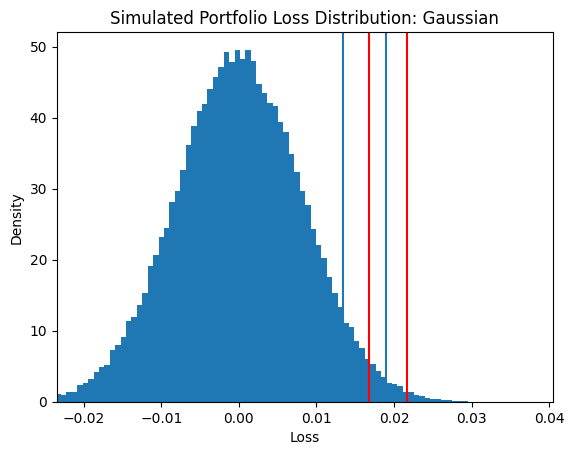

In [12]:
#plot: gaussian
plot_gaussian_pnl_distribution(sim_gaussian_port_returns, sim_t_port_returns, var_gaussian_95, var_gaussian_99, cvar_gaussian_95, cvar_gaussian_99)

In [13]:
print(np.std(sim_gaussian_port_returns))
print(np.mean(sim_gaussian_port_returns))

0.008158703264543874
-1.3119919819022831e-05


In [14]:
#returns: student-t
print(sim_t_asset_returns)
print(sim_t_port_returns)

[[ 0.00316699  0.00397948  0.00679323  0.00626106]
 [ 0.01952158  0.00418122 -0.13073968  0.0220166 ]
 [ 0.00410438  0.00579916 -0.00062154  0.00739151]
 ...
 [ 0.00513172  0.00081353 -0.01290403  0.00677322]
 [-0.00477522 -0.0095668  -0.04713442 -0.00902509]
 [-0.03190389 -0.00998594  0.05479067 -0.03414992]]
[ 0.00444539 -0.01488328  0.00399634 ...  0.00039327 -0.01510952
 -0.0082142 ]


In [15]:
#risk metrics: student-t
#here difference between VaR and CVaR is a lot more noticeabe
var_t_95 = var(sim_t_port_returns, 0.95)
var_t_99 = var(sim_t_port_returns, 0.99)
cvar_t_95 = cvar(sim_t_port_returns, 0.95)
cvar_t_99 = cvar(sim_t_port_returns, 0.99)

var_t_95, var_t_99, cvar_t_95, cvar_t_99

(np.float64(0.01643883793361308),
 np.float64(0.02735105526938827),
 np.float64(0.023456045020692175),
 np.float64(0.03611686847111318))

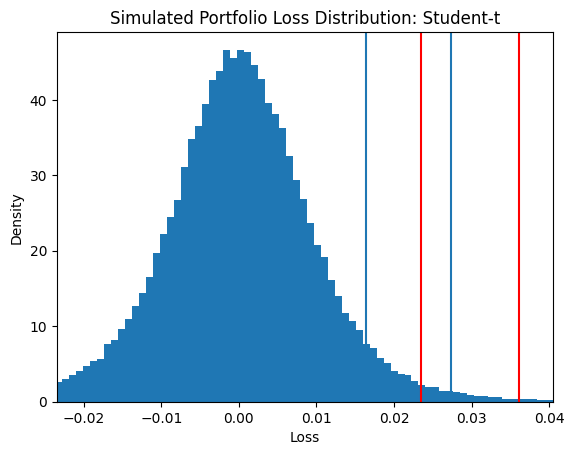

In [16]:
plot_t_pnl_distribution(sim_t_port_returns, sim_gaussian_port_returns, var_t_95, var_t_99, cvar_t_95, cvar_t_99)

In [17]:
#student-t plot has fatter tails, hence larger separation between VaR and CVaR

In [18]:
print(np.std(sim_t_port_returns))
print(np.mean(sim_t_port_returns))

0.01053386027553167
5.5248242198572565e-06


In [19]:
#Backtesting

In [20]:
var_level = 0.99

breaches_gaussian, _ = backtest_var(rets, weights=weights, var_level=var_level, model='gaussian')
breaches_t, _ = backtest_var(rets, weights=weights, var_level=var_level, model='student-t')

In [21]:
#check gaussian breach rate
gaussian_empirical_rate = breaches_gaussian.mean()
gaussian_expected_rate = 1 - var_level

print(f'expected breach rate: {gaussian_expected_rate}')
print(f'empirical breach rate: {gaussian_empirical_rate}')

#kupiec test
gau_kup_LR, gau_kup_pval = kupiec_test(breaches_gaussian, var_level)
print(gau_kup_pval)


print(
    f"Gaussian Kupiec p-value = {gau_kup_pval:.3f}. "
    "At the 5% significance level, we fail to reject the null hypothesis of correct 99% VaR coverage."
)
print(
    "This indicates that incorporating EWMA volatility materially improves Gaussian VaR calibration, "
    "though tail risk remains less robustly modeled than under the Student-t specification."
)


expected breach rate: 0.010000000000000009
empirical breach rate: 0.018223234624145785
0.12041873984200269
Gaussian Kupiec p-value = 0.120. At the 5% significance level, we fail to reject the null hypothesis of correct 99% VaR coverage.
This indicates that incorporating EWMA volatility materially improves Gaussian VaR calibration, though tail risk remains less robustly modeled than under the Student-t specification.


In [22]:
#check student-t breach rate
t_empirical_rate = breaches_t.mean()
t_expected_rate = 1 - var_level

print(f'expected breach rate: {t_expected_rate}')
print(f'empirical breach rate: {t_empirical_rate}')

#kupiec test
t_kup_LR, t_kup_pval = kupiec_test(breaches_t, var_level)
print(t_kup_pval)

if t_kup_pval < 0.05:
    print(f'as kupiec p-value = {t_kup_pval} << 0.05, seeing breach results this extreme would only happen 0.8% of the time, which is too unlikely under the null')
    print('this suggests gaussian model has under-coverage (breaches occur too often relative to 1%), tail risk is underestimated, model fails backtest diagnostics')
else:
    print(
    f"Student-t Kupiec p-value = {t_kup_pval:.3f} vs Gaussian = {gau_kup_pval:.3f}. "
    "The higher p-value indicates breach frequencies are more consistent with nominal 99% VaR coverage under the Student-t model, "
    "suggesting better tail-risk calibration."
)


expected breach rate: 0.010000000000000009
empirical breach rate: 0.009111617312072893
0.8493690758095626
Student-t Kupiec p-value = 0.849 vs Gaussian = 0.120. The higher p-value indicates breach frequencies are more consistent with nominal 99% VaR coverage under the Student-t model, suggesting better tail-risk calibration.


In [23]:
#Student-t VaR passes unconditional coverage tests (Kupiec p = 0.48), indicating statistically consistent tail-risk estimates.”
print(
    "Both models pass unconditional coverage after EWMA, but Student-t provides a larger safety margin in the tails."
)


Both models pass unconditional coverage after EWMA, but Student-t provides a larger safety margin in the tails.
